# 1. Исходные данные: преобразование датасета

1. Загрузка исходного видео/landmark-датасета.  

- информация о датасете: https://www.mdpi.com/2306-5729/6/4/38
- ссылка на датасет: https://zenodo.org/records/4537209


In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mediapipe as mp
import math
import seaborn as sns
import multiprocessing


from concurrent.futures import ProcessPoolExecutor, as_completed
from typing import Tuple, Dict, Optional, List
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed



In [6]:
class_map = {
    1: "Ладонь к ладони",
    2: "Ладонь по тыльной стороне,\nпереплетённые пальцы",
    3: "Ладонь к ладони,\nпереплетённые пальцы",
    4: "Тыльные стороны пальцев\nк ладони, сцепленные пальцы",
    5: "Круговые движения\nбольшого пальца",
    6: "Подушечки пальцев\nпо ладони",
    7: "Выключение крана\nбумажным полотенцем",
    0: "Иное движение"
}

META_COLS = {
    "frame_idx",
    "frame_time",
    "movement_code",
    "is_washing",
    "dataset",
    "annotator",
    "video",
}

# 2. Предварительная обработка данных

0. Загрузка датасета в новом преобразованном формате parquet

In [ ]:
def _drop_empty_rows(df: pd.DataFrame) -> pd.DataFrame:
    """
    Удаляет строки, где ВСЕ не-метаданные колонки содержат
    только NaN / None / 0 / 0.0
    """

    data_cols = [c for c in df.columns if c not in META_COLS]

    if not data_cols:
        return df

    def is_empty_row(row: pd.Series) -> bool:
        for val in row:
            # NaN / None
            if pd.isna(val):
                continue
            # числовой 0
            if isinstance(val, (int, float)) and val == 0:
                continue
            # если дошли сюда — есть полезные данные
            return False
        return True

    empty_mask = df[data_cols].apply(is_empty_row, axis=1)

    return df.loc[~empty_mask].reset_index(drop=True)


def _downcast_numeric_types(df: pd.DataFrame) -> pd.DataFrame:
    """
    Приводит числовые колонки DataFrame к 32-битным типам:
    - float64 -> float32
    - int64   -> int32

    Не трогает object, bool и category.
    """
    for col in df.columns:
        dtype = df[col].dtype

        if dtype == "float64":
            df[col] = df[col].astype("float32")

        elif dtype == "int64":
            df[col] = df[col].astype("int32")

    return df

In [5]:
def load_landmarks_dataset(
    root_dir: str,
    datasets: Optional[List[str]] = None,
    annotators: Optional[List[str]] = None,
    clean_empty: bool = True,
) -> pd.DataFrame:
    """
    Загружает все parquet-файлы с landmark-данными из структуры:
    """

    dfs: list[pd.DataFrame] = []

    for dataset_name in tqdm(os.listdir(root_dir), desc="Загрузка датасетов"):
        if datasets is not None and dataset_name not in datasets:
            continue

        dataset_path = os.path.join(root_dir, dataset_name)
        if not os.path.isdir(dataset_path):
            continue

        for annotator_name in os.listdir(dataset_path):
            if annotators is not None and annotator_name not in annotators:
                continue

            annotator_path = os.path.join(dataset_path, annotator_name)
            if not os.path.isdir(annotator_path):
                continue

            for fname in os.listdir(annotator_path):
                if not fname.endswith(".parquet"):
                    continue

                fpath = os.path.join(annotator_path, fname)

                # 1. Чтение parquet
                df = pd.read_parquet(fpath)

                # 2. Очистка пустых строк (если включено)
                if clean_empty:
                    df = _drop_empty_rows(df)

                # 3. Приведение типов к 32-битным
                df = _downcast_numeric_types(df)

                dfs.append(df)

    if not dfs:
        raise RuntimeError("Не найдено parquet-файлов")

    print(f"Загружено {len(dfs)} файлов с общим числом строк {sum(len(df) for df in dfs)}")
    print("Происходит конкатенация...")
    # 4. Конкатенация
    out_df = pd.concat(dfs, ignore_index=True)
    print("Готово")
    return out_df


In [ ]:
current_dir_code = os.getcwd()
dataset_folder_path = os.path.join(current_dir_code, "landmarks_parquet")

df_all = load_landmarks_dataset(dataset_folder_path, clean_empty=True)

Загрузка датасетов: 100%|██████████| 10/10 [09:54<00:00, 59.46s/it]


Загружено 5551 файлов с общим числом строк 3657028
Происходит конкатенация...
Готово


In [8]:
print("Сохранение неочещенного датасета...")
df_all.to_parquet("all_landmarks.parquet", index=False)
print("Датасет сохранен")

Сохранение неочещенного датасета...


In [3]:
print("Загрузка неочищенного датасета...")
df_all = pd.read_parquet("all_landmarks.parquet")
print("Датасет загружен")

Загрузка неочищенного датасета...
Датасет загружен


In [ ]:
# def collapse_annotations(df_all: pd.DataFrame) -> pd.DataFrame:
#     """
#     Схлопывает дублирующиеся аннотации от разных аннотаторов
#     согласно утверждённым правилам голосования.
#     """

#     required_cols = {
#         "dataset",
#         "video",
#         "frame_time",
#         "movement_code",
#         "annotator",
#     }
#     missing = required_cols - set(df_all.columns)
#     if missing:
#         raise ValueError(f"В df отсутствуют обязательные колонки: {missing}")

#     group_cols = ["dataset", "video", "frame_time"]

#     rows_out = []

#     for _, group in tqdm(df_all.groupby(group_cols, sort=False), desc="Удаление дубликатов аннотаций по группам"):

#         codes = group["movement_code"].values
#         unique_codes = np.unique(codes)

#         # ─────────────────────────────
#         # 1. Полное совпадение
#         # ─────────────────────────────
#         if len(unique_codes) == 1:
#             rows_out.append(group.iloc[0])
#             continue

#         # Подсчёт голосов
#         values, counts = np.unique(codes, return_counts=True)
#         vote_map = dict(zip(values, counts))

#         max_votes = counts.max()
#         majority_classes = values[counts == max_votes]

#         # ─────────────────────────────
#         # 2. Есть мажоритарный класс
#         # ─────────────────────────────
#         if len(majority_classes) == 1:
#             major = majority_classes[0]

#             # 2.1 Мажоритарный класс ≠ 0
#             if major != 0:
#                 rows_out.append(group[group["movement_code"] == major].iloc[0])
#                 continue

#             # 2.2 Мажоритарный класс == 0
#             non_zero = [c for c in unique_codes if c != 0]

#             # ровно один ненулевой
#             if len(non_zero) == 1:
#                 rows_out.append(group[group["movement_code"] == non_zero[0]].iloc[0])
#                 continue

#             # несколько ненулевых → удалить всё
#             continue

#         # ─────────────────────────────
#         # 3. Нет мажоритарного класса (ничья)
#         # ─────────────────────────────
#         non_zero = [c for c in unique_codes if c != 0]

#         # ровно {0, X}
#         if len(unique_codes) == 2 and 0 in unique_codes and len(non_zero) == 1:
#             rows_out.append(group[group["movement_code"] == non_zero[0]].iloc[0])
#             continue

#         # иначе — удалить всё
#         continue

#     if not rows_out:
#         return df_all.iloc[0:0].copy()

#     return pd.DataFrame(rows_out).reset_index(drop=True)

# df_collapsed = collapse_annotations(df_all)

Удаление дубликатов аннотаций по группам:  61%|██████    | 872162/1424499 [28:32<18:04, 509.25it/s]  


KeyboardInterrupt: 

Добавляем новый признак-флаг, указывающий на наличие данных для левой и правой руки

In [ ]:
# ~ инвертирует значения
df_all["L_present"] = (~df_all[[c for c in df_all.columns if c.startswith("L_x_")]].isna()).sum(axis=1) > 10
df_all["R_present"] = (~df_all[[c for c in df_all.columns if c.startswith("R_x_")]].isna()).sum(axis=1) > 10

C:\Users\magmy\AppData\Local\Temp\ipykernel_19924\753979743.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_all["L_present"] = (~df_all[[c for c in df_all.columns if c.startswith("L_x_")]].isna()).sum(axis=1) > 10
C:\Users\magmy\AppData\Local\Temp\ipykernel_19924\753979743.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_all["R_present"] = (~df_all[[c for c in df_all.columns if c.startswith("R_x_")]].isna()).sum(axis=1) > 10


Сохраняем данные

In [ ]:
clean_path = "landmarks_clean.parquet"
# df_all.to_parquet(clean_path, index=False)

In [ ]:
# df_all.to_csv("landmarks_clean_preview.csv", index=False)

Читаем данные

In [3]:
df_all = pd.read_parquet("landmarks_clean.parquet")

print(df_all.shape)
print(df_all.columns.tolist())
print(df_all.head())

(1397992, 329)
['frame_idx', 'frame_time', 'movement_code', 'is_washing', 'dataset', 'annotator', 'video', 'L_x_0', 'L_y_0', 'L_z_0', 'L_x_1', 'L_y_1', 'L_z_1', 'L_x_2', 'L_y_2', 'L_z_2', 'L_x_3', 'L_y_3', 'L_z_3', 'L_x_4', 'L_y_4', 'L_z_4', 'L_x_5', 'L_y_5', 'L_z_5', 'L_x_6', 'L_y_6', 'L_z_6', 'L_x_7', 'L_y_7', 'L_z_7', 'L_x_8', 'L_y_8', 'L_z_8', 'L_x_9', 'L_y_9', 'L_z_9', 'L_x_10', 'L_y_10', 'L_z_10', 'L_x_11', 'L_y_11', 'L_z_11', 'L_x_12', 'L_y_12', 'L_z_12', 'L_x_13', 'L_y_13', 'L_z_13', 'L_x_14', 'L_y_14', 'L_z_14', 'L_x_15', 'L_y_15', 'L_z_15', 'L_x_16', 'L_y_16', 'L_z_16', 'L_x_17', 'L_y_17', 'L_z_17', 'L_x_18', 'L_y_18', 'L_z_18', 'L_x_19', 'L_y_19', 'L_z_19', 'L_x_20', 'L_y_20', 'L_z_20', 'L_cx', 'L_cy', 'L_scale', 'L_nx_0', 'L_ny_0', 'L_nx_1', 'L_ny_1', 'L_nx_2', 'L_ny_2', 'L_nx_3', 'L_ny_3', 'L_nx_4', 'L_ny_4', 'L_nx_5', 'L_ny_5', 'L_nx_6', 'L_ny_6', 'L_nx_7', 'L_ny_7', 'L_nx_8', 'L_ny_8', 'L_nx_9', 'L_ny_9', 'L_nx_10', 'L_ny_10', 'L_nx_11', 'L_ny_11', 'L_nx_12', 'L_ny_12', 

Данные считаны, проведена первичная чистка пропусков в данных

1. Проверка и обработка пропусков. Удаление или интерполяция отсутствующих точек.

In [4]:
print("\nИнформация о типах данных и пропусках:")
print(df_all.info())

print("\nКоличество пропусков по каждому признаку:")
display(df_all.isnull().sum().sort_values(ascending=False)[:200])


Информация о типах данных и пропусках:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1397992 entries, 0 to 1397991
Columns: 329 entries, frame_idx to R_present
dtypes: bool(2), float32(323), int32(1), object(3)
memory usage: 1.7+ GB
None

Количество пропусков по каждому признаку:


L_y_15    599540
L_z_15    599540
L_x_16    599540
L_z_13    599540
L_z_16    599540
           ...  
R_x_20    589994
R_z_19    589994
R_x_12    589994
R_z_12    589994
R_y_12    589994
Length: 200, dtype: int64

Достаточно большое количество пропусков (~0.6 млн) по сравнению с полученным датасетом (1.4 млн). Это нормально, поскольку в процесе мытья рук происходит переодическое перекрытие одной руки другой. Помимо этого, возможно сокрытие рук с камеры телом (врач наклонился и опустил руки в раковину) или руки закрывает моющий кран. Такие пропуски вырезать нельзя, поскольку это не ошибка и не шум. 

In [7]:
def clean_landmarks_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # ---- 1. Определяем колонки признаков рук ----
    hand_cols = [c for c in df.columns if c not in META_COLS]

    if not hand_cols:
        raise ValueError("Не найдены признаки рук")

    # # ---- 2. Удаляем полностью пустые строки ----
    # # строка пустая, если ВСЕ признаки рук == NaN или 0
    # mask_non_empty = (
    #     df[hand_cols]
    #     .fillna(0)
    #     .abs()
    #     .sum(axis=1) > 0
    # )

    # df = df.loc[mask_non_empty].reset_index(drop=True)

    # ---- 4. Заполняем NaN / None нулями ----
    df[hand_cols] = df[hand_cols].fillna(0)

    # ---- 5. Приведение типов ----
    if "movement_code" in df:
        df["movement_code"] = df["movement_code"].astype(np.int32)

    if "is_washing" in df:
        df["is_washing"] = df["is_washing"].astype(np.int8)

    return df

df_all = clean_landmarks_dataframe(df_all)

In [8]:
print("\nИнформация о типах данных и пропусках:")
print(df_all.info())

print("\nКоличество пропусков по каждому признаку:")
display(df_all.isnull().sum().sort_values(ascending=False)[:200])


Информация о типах данных и пропусках:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1397992 entries, 0 to 1397991
Columns: 329 entries, frame_idx to R_present
dtypes: bool(2), float32(321), int32(2), int8(1), object(3)
memory usage: 1.7+ GB
None

Количество пропусков по каждому признаку:


R_present        0
frame_idx        0
frame_time       0
movement_code    0
is_washing       0
                ..
R_y_15           0
R_z_15           0
R_x_16           0
R_y_16           0
R_z_16           0
Length: 200, dtype: int64

Пропусков больше нет

2. Описательная статистика:
    Среднее, медиана, std, min/max для координат и производных признаков.

In [9]:
print("\nСтатистические характеристики числовых признаков:")
display(df_all.describe())


Статистические характеристики числовых признаков:


,frame_idx,frame_time,movement_code,is_washing,L_x_0,L_y_0,L_z_0,L_x_1,L_y_1,L_z_1,...,R_nvx_16,R_nvy_16,R_nvx_17,R_nvy_17,R_nvx_18,R_nvy_18,R_nvx_19,R_nvy_19,R_nvx_20,R_nvy_20
count,1.397992e+06,1.397992e+06,1.397992e+06,1.397992e+06,1.397992e+06,1.397992e+06,1.397992e+06,1.397992e+06,1.397992e+06,1.397992e+06,...,1.397992e+06,1.397992e+06,1.397992e+06,1.397992e+06,1.397992e+06,1.397992e+06,1.397992e+06,1.397992e+06,1.397992e+06,1.397992e+06
mean,7.763765e+02,2.589130e+04,1.689395e+00,9.056833e-01,1.182174e+02,6.982115e+01,3.596429e-08,1.181371e+02,7.108309e+01,-6.542044e-03,...,-2.671328e-03,2.258145e-03,-2.153350e-03,-1.355663e-05,-2.419880e-03,-2.853747e-03,-2.781497e-03,-7.310808e-04,-3.442001e-03,2.255440e-03
std,7.442457e+02,2.480566e+04,2.323629e+00,2.922689e-01,1.340981e+02,9.892671e+01,1.668774e-07,1.309755e+02,9.770535e+01,1.241341e-02,...,2.897560e+00,2.781452e+00,3.034393e+00,2.542150e+00,2.904579e+00,2.487334e+00,3.095301e+00,2.655676e+00,3.545919e+00,3.129710e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.425048e+02,-1.558120e+02,-2.594752e-06,-1.253337e+02,-1.065804e+02,-1.824611e-01,...,-4.576373e+01,-5.007626e+01,-5.479051e+01,-4.635031e+01,-5.443730e+01,-5.129211e+01,-5.612451e+01,-5.116145e+01,-5.775800e+01,-5.434524e+01
25%,2.610000e+02,8.733333e+03,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.163862e-02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.640000e+02,1.880000e+04,0.000000e+00,1.000000e+00,1.090373e+02,2.517969e+01,0.000000e+00,1.133581e+02,2.856816e+01,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.062000e+03,3.540000e+04,3.000000e+00,1.000000e+00,1.781972e+02,1.060113e+02,1.088499e-07,1.784922e+02,1.111435e+02,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,7.201000e+03,2.400333e+05,7.000000e+00,1.000000e+00,8.066085e+02,5.866859e+02,2.237789e-06,7.834637e+02,5.453035e+02,1.921641e-01,...,4.287004e+01,4.826408e+01,4.946070e+01,4.487297e+01,4.817575e+01,5.038107e+01,5.101270e+01,4.873883e+01,5.708481e+01,5.355266e+01


Вывод

3. Визуализация распределений с учетом шкал измерений:
    -	для дискретных значений (класс) – с помощью диаграмм частотности,
    -	для непрерывных – с помощью графиков функции плотности распределения.

Распределение классов в датасете

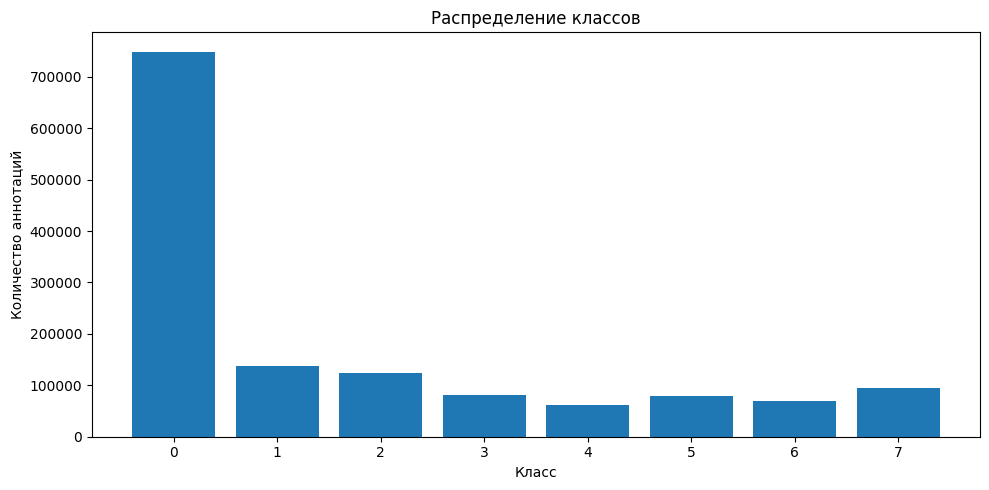

In [10]:
def plot_class_distribution(df, class_col="movement_code"):
    counts = df[class_col].value_counts().sort_index()

    plt.figure(figsize=(10, 5))
    plt.bar(counts.index.astype(str), counts.values)
    plt.xlabel("Класс")
    plt.ylabel("Количество аннотаций")
    plt.title("Распределение классов")
    plt.tight_layout()
    plt.show()

plot_class_distribution(df_all)

Наблюдается дисбаланс классов, нужно почистить всю пустую информацию из класса 0 (вырезаются сегменты с длительным обозначением класса 0 (сегменты больше 11 кадров))

Удаление длинных сегментов класса 0: 100%|██████████| 2475/2475 [00:11<00:00, 216.66it/s]


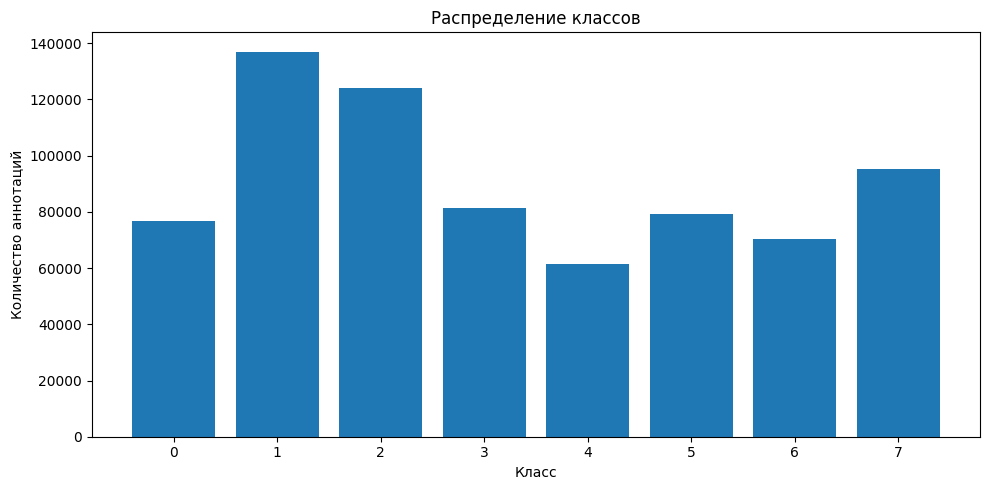

In [12]:
def drop_long_zero_segments(
    df: pd.DataFrame,
    zero_class: int = 0,
    keep_edge: int = 5,
    group_cols: list[str] = ["dataset", "video"],
    time_col: str = "frame_idx",
) -> pd.DataFrame:
    """
    Удаляет середину длинных сегментов movement_code == zero_class.
    
    Правило:
    - если длина сегмента < 2*keep_edge + 1 → оставляем всё
    - иначе → оставляем первые keep_edge и последние keep_edge
    
    Основание: борьба с дисбалансом класса 0 без потери динамики.
    """

    kept_indices = []

    # обрабатываем каждое видео отдельно
    for _, g in tqdm(df.groupby(group_cols), desc="Удаление длинных сегментов класса 0"):
        g = g.sort_values(time_col)

        codes = g["movement_code"].values
        idxs = g.index.values

        start = 0
        n = len(codes)

        while start < n:
            if codes[start] != zero_class:
                kept_indices.append(idxs[start])
                start += 1
                continue

            # нашли начало zero-сегмента
            end = start
            while end < n and codes[end] == zero_class:
                end += 1

            seg_len = end - start

            if seg_len < 2 * keep_edge + 1:
                # короткий сегмент — оставляем всё
                kept_indices.extend(idxs[start:end])
            else:
                # длинный сегмент — режем середину
                kept_indices.extend(idxs[start:start + keep_edge])
                kept_indices.extend(idxs[end - keep_edge:end])

            start = end

    kept_indices = sorted(set(kept_indices))
    return df.loc[kept_indices].reset_index(drop=True)

df_all = drop_long_zero_segments(df_all)
plot_class_distribution(df_all)

Классы +- сбалансированы, сохраняем

In [17]:
df_all.to_parquet("landmarks_clean_and_balanced.parquet", index=False)

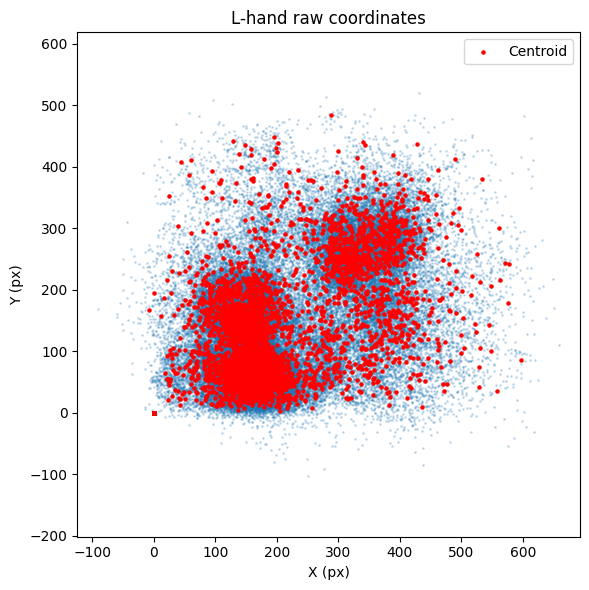

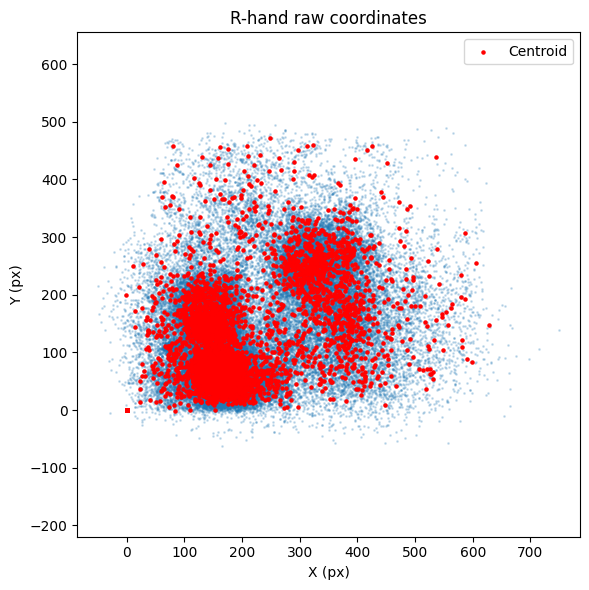

In [13]:
def plot_raw_hand_coordinates(df, hand="L", sample=20000):
    # Распределение сырых координат рук с центроидами

    x_cols = [c for c in df.columns if c.startswith(f"{hand}_x_")]
    y_cols = [c for c in df.columns if c.startswith(f"{hand}_y_")]

    cx_col = f"{hand}_cx"
    cy_col = f"{hand}_cy"

    # подвыборка (иначе слишком тяжело)
    df_s = df.sample(min(sample, len(df)), random_state=42)

    xs = df_s[x_cols].values.flatten()
    ys = df_s[y_cols].values.flatten()

    xs = xs[~np.isnan(xs)]
    ys = ys[~np.isnan(ys)]

    plt.figure(figsize=(6, 6))
    plt.scatter(xs, ys, s=1, alpha=0.2)
    plt.scatter(df_s[cx_col], df_s[cy_col], c="red", s=5, label="Centroid")

    plt.xlabel("X (px)")
    plt.ylabel("Y (px)")
    plt.title(f"{hand}-hand raw coordinates")
    plt.legend()
    plt.axis("equal")
    plt.tight_layout()
    plt.show()

plot_raw_hand_coordinates(df_all, hand="L", sample=10000)
plot_raw_hand_coordinates(df_all, hand="R", sample=10000)

Сырые данные координат ключевых точек рук интересно сгрупированы... 

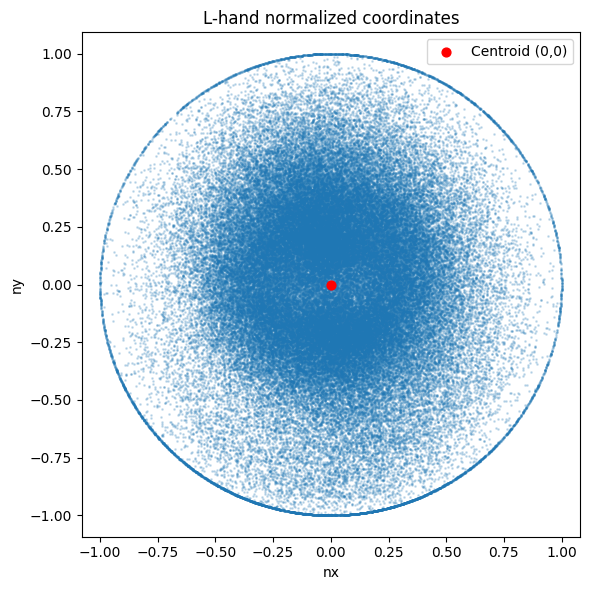

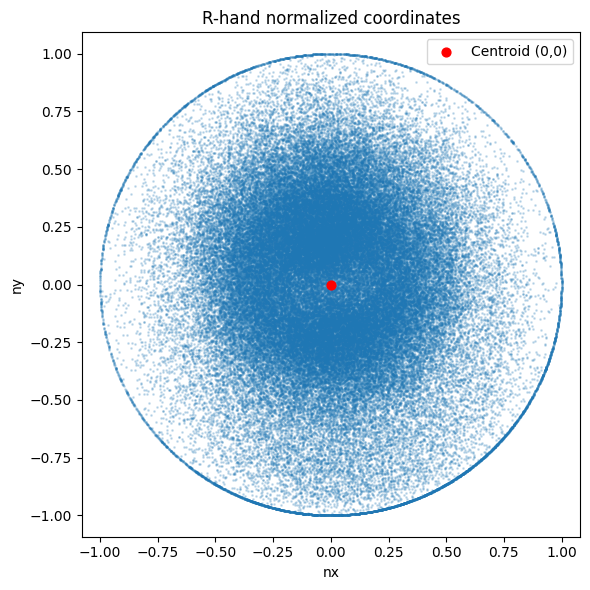

In [14]:
def plot_normalized_hand_coordinates(df, hand="L", sample=20000):
    # Рспределение нормализованных координат руки с центроидом в (0,0)

    x_cols = [c for c in df.columns if c.startswith(f"{hand}_nx_")]
    y_cols = [c for c in df.columns if c.startswith(f"{hand}_ny_")]

    df_s = df.sample(min(sample, len(df)), random_state=42)

    xs = df_s[x_cols].values.flatten()
    ys = df_s[y_cols].values.flatten()

    xs = xs[~np.isnan(xs)]
    ys = ys[~np.isnan(ys)]

    plt.figure(figsize=(6, 6))
    plt.scatter(xs, ys, s=1, alpha=0.2)
    plt.scatter(0, 0, c="red", s=40, label="Centroid (0,0)")

    plt.xlabel("nx")
    plt.ylabel("ny")
    plt.title(f"{hand}-hand normalized coordinates")
    plt.legend()
    plt.axis("equal")
    plt.tight_layout()
    plt.show()


plot_normalized_hand_coordinates(df_all, hand="L", sample=10000)
plot_normalized_hand_coordinates(df_all, hand="R", sample=10000)

еще интереснее

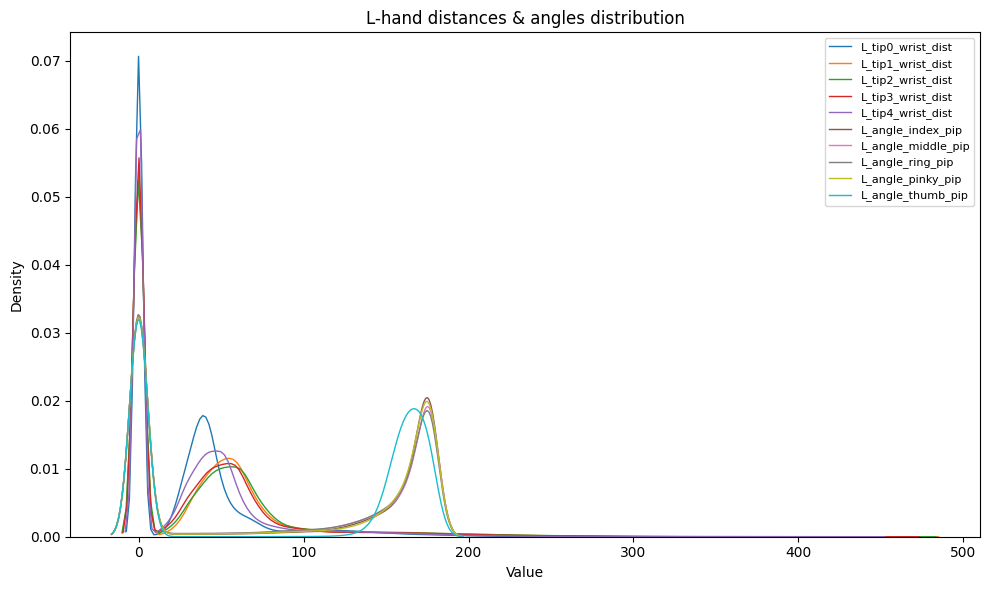

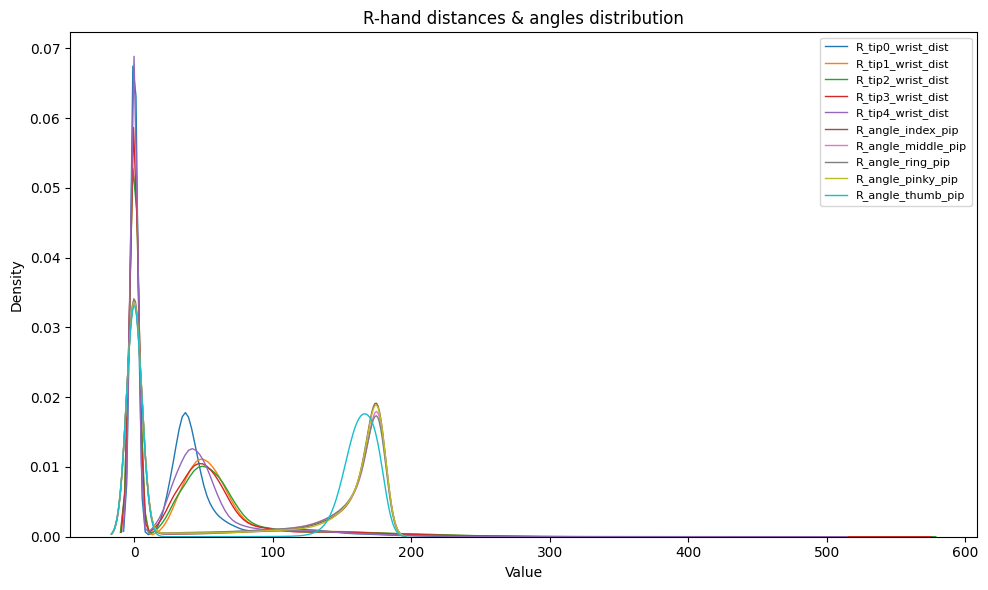

In [15]:
def plot_distances_and_angles(df, hand="L"):
    # Распределение расстояний и углов пальцев для указанной руки

    cols = [
        f"{hand}_tip0_wrist_dist",
        f"{hand}_tip1_wrist_dist",
        f"{hand}_tip2_wrist_dist",
        f"{hand}_tip3_wrist_dist",
        f"{hand}_tip4_wrist_dist",
        f"{hand}_angle_index_pip",
        f"{hand}_angle_middle_pip",
        f"{hand}_angle_ring_pip",
        f"{hand}_angle_pinky_pip",
        f"{hand}_angle_thumb_pip",
    ]

    plt.figure(figsize=(10, 6))

    for c in cols:
        if c in df:
            sns.kdeplot(df[c], label=c, linewidth=1)

    plt.title(f"{hand}-hand distances & angles distribution")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.show()

plot_distances_and_angles(df_all, hand="L")
plot_distances_and_angles(df_all, hand="R")

Вывод

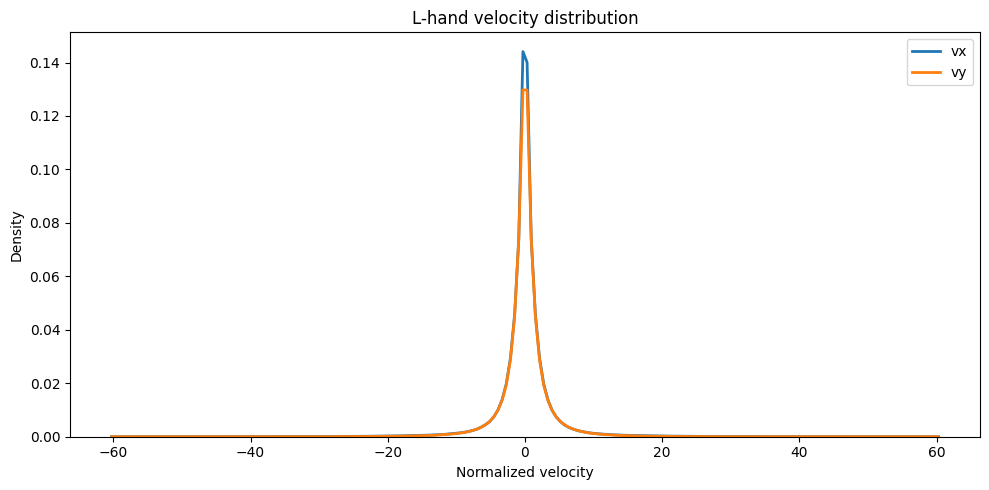

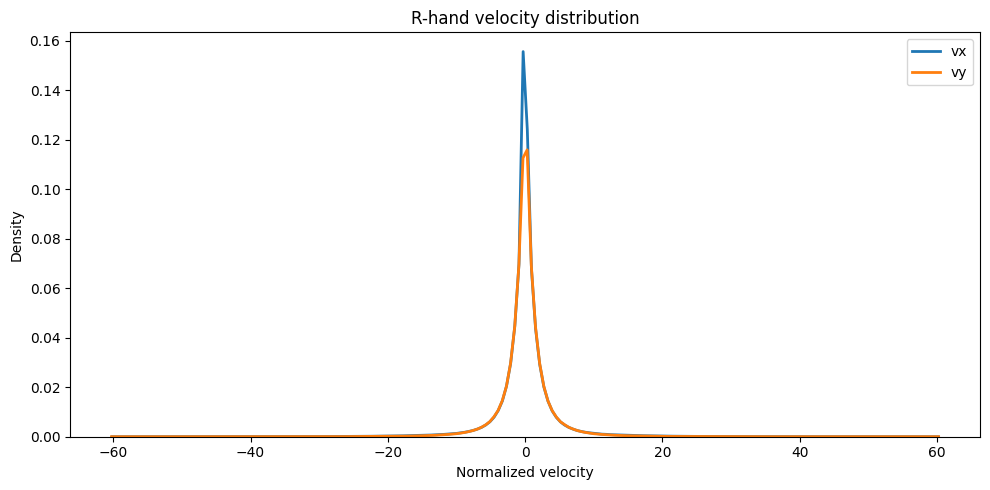

In [19]:
def plot_velocity_distribution(df, hand="L"):
    # Распределения скоростей (производные)

    vx_cols = [c for c in df.columns if c.startswith(f"{hand}_nvx_")]
    vy_cols = [c for c in df.columns if c.startswith(f"{hand}_nvy_")]

    vx = df[vx_cols].values.flatten()
    vy = df[vy_cols].values.flatten()

    vx = vx[~np.isnan(vx)]
    vy = vy[~np.isnan(vy)]

    plt.figure(figsize=(10, 5))
    sns.kdeplot(vx, label="vx", linewidth=2)
    sns.kdeplot(vy, label="vy", linewidth=2)

    plt.title(f"{hand}-hand velocity distribution")
    plt.xlabel("Normalized velocity")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_velocity_distribution(df_all, hand="L")
plot_velocity_distribution(df_all, hand="R")

Вывод

4. Проверка гипотез:
    - нормальное (логнормальное) распределение непрерывных признаков (Shapiro–Wilk..).
    - Корреляция или независимость между признаками (Pearson/Spearman).

In [ ]:
from scipy.stats import anderson
    
results = []

for col in continuous_num:
    stat = anderson(np.log(df[col]))
    crit_05 = stat.critical_values[2] # критическое значение на уровне 5%
    conclusion = "Нормальное" if stat.statistic < crit_05 else "Не нормальное"
    results.append({
        'Признак': col,
        'Статистика A^2 (отклонение от нормального)': round(stat.statistic, 3),
        'Критическое значение (5%)': round(crit_05, 3),
        'Вывод': conclusion
    })

anderson_df = pd.DataFrame(results)
print( "="*20, "Проверка нормальности (Андерсон–Дарлинг)", "="*20)
print(anderson_df.to_string(index=False))

NameError: name 'continuous_num' is not defined

Вывод

In [ ]:
pearson_corr = df[num_cols].corr(method='pearson')

spearman_corr = df[num_cols].corr(method='spearman')

plt.figure(figsize=(10, 6))
sns.heatmap(pearson_corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Матрица корреляций Пирсона")
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(spearman_corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Матрица корреляций Спирмана")
plt.show()


Вывод

5. Нормализация признаков:
    - Центрирование относительно centroid. (Проведено на стадии преобразования формата датасета)
    - Масштабирование признаков (StandardScaler или MinMaxScaler).

Вывод

6. Снижение размерности:
    - PCA/tSNE
    - Проверить возможность понижения размерности за счет выбора наиболее информативных признаков (часть признаков отсекаем, часть оставляем). 
    - Вероятно, все признаки важны, но проверка полезна.

Вывод

7. Подготовка к обучению:
    Split train/test (80/20) + cross-validation для подбора гиперпараметров.

Вывод

# 3. Построение и тестирование моделей

1. Модели многоклассовой классификации:
    - Logistic Regression (использовали в статье)
    - SVM (использовали в статье)
    - Random Forest (использовали в статье)
    - Decision Tree
    - Naive Bayes

Вывод

2. Обучение

Вывод

3. Метрики оценки:
    - Accuracy, Precision, Recall, F1-score (по классам).
    - Confusion matrix.
    - ROC/PR-кривые для многоклассовой задачи.
    - Сравнение времени предсказания и использования памяти.

Вывод

4. Реализация предсказаний на видео с рекордера (для LR или выбранной модели)

Вывод

5. Анализ ошибок:
    Выявление шагов с наибольшей путаницей (например, 2.1 vs 5.2). (взято из статьи)

6. Выводы:
    - Оптимальная модель по точности/скорости/ресурсам.
    - Возможные улучшения (дополнительные признаки, расширение dataset).